# Implementation of FIR Filter in the FPGA

In [147]:
import numpy as np
from numpy import savetxt, loadtxt
import matplotlib.pyplot as plt

In [148]:
# Let us generate a wave function with two main frequencies, an high one and a low one:

data_size = 125
noise = 1 # the higher the noisier
file = open("../signal.txt", "w")

input_sig = []

for i in range(data_size):
    sig = 62*(np.sin(i/(2*np.pi))+ noise)
    noise = -noise
    input_sig.append(sig.astype(int)) # we write it as an int
    file.write(str(sig.astype(int)))
    file.write('\n')

file.close()

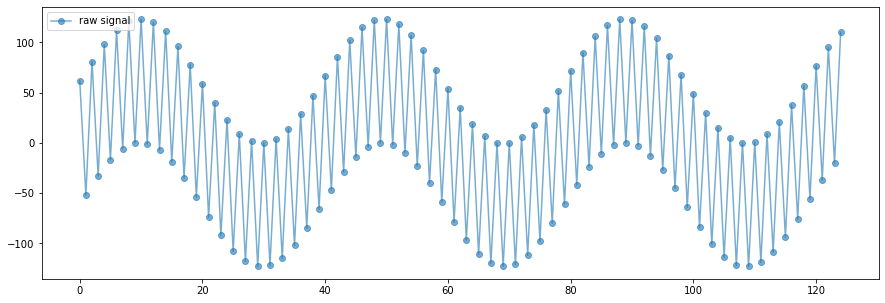

In [149]:
# Now we visualize it:
sig = np.loadtxt("../signal.txt", delimiter='\n')
t = np.arange(len(input_sig)) # array for the x coordinate, just for displaying

plt.figure(figsize=(15, 5))

plt.plot(t, sig, '-o',alpha=.6,label='raw signal')
plt.legend(loc="upper left")

In [150]:
# After being computed on the actual FPGA

In [151]:
# I just copied from the terminal, had some problems in reading from a file :/
fpga = [0,0,0,0,0,6,2,3,5,8,10,11,13,14,15,15,15,14,14,12,11,9,7,5,3,0,-2,-5,-7,-9,-11,-13,-14,-15,-16,-16,-16,-15,-14,-13,-11,-10,-7,-5,-3,0,2,4,7,9,10,12,13,14,15,15,15,14,13,12,10,8,6,4,1,-1,-4,-6,-8,-10,-12,-13,-15,-15,-16,-16,-16,-15,-14,-12,-10,-9,-6,-4,-2,1,3,6,8,10,11,13,14,15,15,15,14,14,12,11,9,7,5,2,0,-2,-5,-7,-9,-11,-13,-14,-15,-16,-16,-16,-15,-14,-13,-11,-10,-7,-5,-3,0]
for i in range(len(fpga)):
    # 2**10 due to truncation of bits
    # 2**9 because I multiplied the coefficients by 2**9
    fpga[i] = (2**10/2**8)*fpga[i]

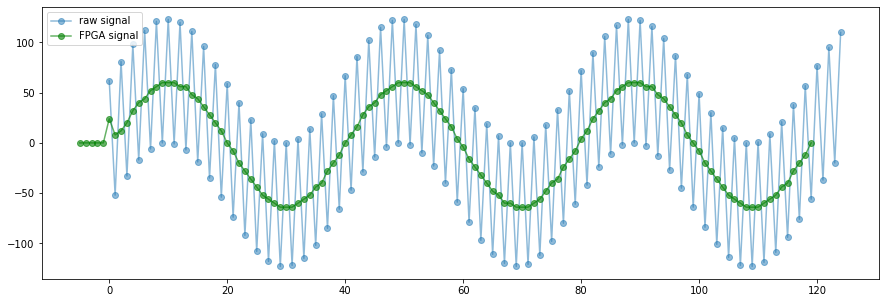

In [152]:
plt.figure(figsize=(15, 5))

t = np.arange(len(input_sig))
plt.plot(t, input_sig, '-o',alpha=.5,label='raw signal')
t = np.arange(len(fpga))
plt.plot(t-5, fpga, '-o', color='g',alpha=.6,label='FPGA signal')

#plt.title("")
#plt.xlim(0,200) #just for the latex report
plt.legend(loc="upper left")

In [153]:
def sine_wave(A, time, f): # creates a sine wave
    return A * np.sin(2 * np.pi * f * time)

In [190]:
data_size = 800

max_amplitude = 126
noise = 40
A1, A2 = max_amplitude - noise, noise
f1, f2, f3 = 2, 50, 100

t = np.linspace(0, 1, data_size)

signal = sine_wave(A1, t, f1) + sine_wave(A2, t, f2)

125.95153139820991 -125.95153139820988


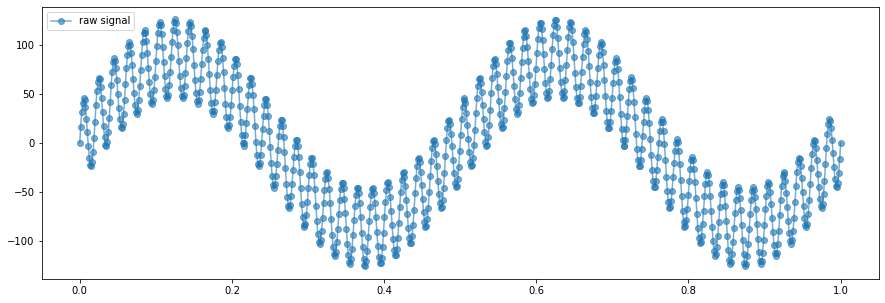

In [191]:
plt.figure(figsize=(15, 5))

plt.plot(t, signal, '-o',alpha=.6,label='raw signal')
plt.legend(loc="upper left")
print(max(signal), min(signal))

In [192]:
np.savetxt('../signal.txt', signal, delimiter='\n', fmt='%d')

In [193]:
from scipy import signal
numtaps = 4
f = 10

# this function gives us the coefficients used in the testbench
c = signal.firwin(numtaps, f, fs=200)
print("Coefficients for the Fir Filter:", c)


Coefficients for the Fir Filter: [0.04566357 0.45433643 0.45433643 0.04566357]


In [194]:
coeffpot = 8
rc = c * 2**coeffpot
print(rc)
trunc_rc = np.round(rc,0).astype(int)
bin_rc = []
hex_rc = []

for i in range(numtaps):
    bin_rc.append(bin(trunc_rc[i]))
    hex_rc.append(hex(trunc_rc[i]))
    
print(bin_rc)
print(hex_rc)

[ 11.68987465 116.31012535 116.31012535  11.68987465]
['0b1100', '0b1110100', '0b1110100', '0b1100']
['0xc', '0x74', '0x74', '0xc']


In [195]:
# After being computed on the actual FPGA

In [196]:
fpga = [0,0,0,0,0,0,1,4,7,9,10,10,9,8,5,2,0,-3,-5,-7,-8,-7,-6,-4,-2,1,4,7,10,12,13,13,13,11,9,6,3,0,-2,-4,-4,-4,-3,-1,2,5,8,11,14,15,17,17,16,14,12,9,6,3,1,0,-1,-1,0,2,5,8,11,14,17,19,20,20,19,17,15,12,9,6,4,2,2,2,3,5,8,11,14,17,20,21,22,23,22,20,17,15,12,9,7,5,4,5,6,8,11,14,17,20,22,24,25,25,24,22,20,17,14,11,9,7,7,7,8,10,13,16,19,22,25,26,27,27,26,24,22,19,16,13,11,9,9,9,10,12,15,18,21,24,26,28,29,29,28,26,23,20,18,15,12,11,10,10,11,13,16,19,22,25,28,29,30,30,29,27,24,21,18,16,13,12,11,11,12,14,17,20,23,26,28,30,31,31,29,27,25,22,19,16,14,12,11,12,13,15,17,20,23,26,29,30,31,31,29,27,25,22,19,16,14,12,11,11,13,15,17,20,23,26,28,30,31,30,29,27,24,21,18,15,13,11,10,11,12,14,17,20,22,25,27,29,30,29,28,26,23,20,17,14,12,10,9,10,11,13,15,18,21,24,26,28,28,28,26,24,21,18,15,12,10,8,8,8,9,11,14,17,19,22,24,26,26,26,24,22,19,16,13,10,8,6,5,6,7,9,12,14,17,20,22,23,24,23,22,20,17,14,11,8,5,4,3,3,4,6,9,12,15,17,20,21,20,6,-2,3,5,12,6,3,-3,-11,-8,0,2,-2,-7,-9,-6,-9,-3,-3,-3,5,3,4,-2,2,-4,1,3,-1,-2,-2,-1,1,-4,-4,6,12,10,-1,-2,-1,-3,-10,-11,-7,0,-2,-5,-5,-6,-6,-4,-2,0,5,-12,-11,-9,-10,-10,-4,6,10,12,-5,0,6,-1,-4,-7,-9,-8,-6,-3,0,4,1,-2,-6,-6,-5,1,-4,-7,-3,-5,-8,-10,-12,-13,-12,-11,-9,-7,-4,-1,2,-2,0,3,1,-10,-1,5,-2,-7,-11,-14,-15,-16,-16,-15,-12,-10,-7,-4,-2,1,5,-3,-13,126,13,14,6,-3,-5,3,12,13,13,13,1,-11,-10,-7,-5,-3,-1,-1,-2,-4,-6,-9,-11,1,12,12,10,10,10,11,12,0,-11,-10,-7,-5,-4,-4,-5,-6,-9,-12,-13,-2,10,9,8,7,8,9,11,12,1,-11,-10,-8,-7,-6,-7,-9,-11,-13,-1,10,9,7,5,5,5,7,9,10,-2,-13,-12,-10,-9,-9,-9,-11,-12,0,11,10,7,5,3,3,3,5,7,10,11,0,-12,-12,-11,-10,-11,-13,-14,-2,9,8,5,3,2,1,2,4,6,9,10,-2,-13,-13,-12,-11,-12,-12,0,11,10,7,4,2,1,0,1,3,5,8,11,12,0,-12,-12,-12,-13,-13,-1,11,9,6,4,2,0,0,1,2,5,8,11,12,0,-12,-13,-12,-13,-13,-1,11,9,6,4,2,0,0,1,3,5,8,9,-2,-14,-13,-12,-12,-13,-13,-1,11,10,7,4,2,1,1,2,3,6,9,10,-1,-13,-12,-11,-11,-12,-12,0,12,11,8,5,3,2,2,3,5,7,10,12,0,-12,-11,-10,-10,-10,-12,-13,-1,11,9,7,5,4,4,5,6,9,11,-1,-12,-11,-9,-8,-8,-8,-10,-12,-14,-2,10,9,7,6,6,7,9,10,-2,-13,-12,-9,-7,-6,-5,-6,-8,-10,-11,0,12,11,9,8,9,10,11,12,1,-10,-9,-6,-4,-3,-3,-3,-5,-7,-10,-11,0,12,12,11,11,12,13,1,-11,-9,-6,-3,-1,0,1,-1,-6,-10,-9,-10,-13,-14,-1,13,13,0,-13,-12,-9,-6,-3,0,3,-4,2,-1,-2,2,-2,-6,-9,-12,-14,-14,-14,-13,-11,-8,-5,-2,1,-4,-10,-10,-12,-3,4,8,3,-2,-5,-8,-10,-11]
for i in range(len(fpga)):
    # 2**10 due to truncation of bits
    # 2**9 because I multiplied the coefficients by 2**9
    fpga[i] = (2**10/2**8)*fpga[i]

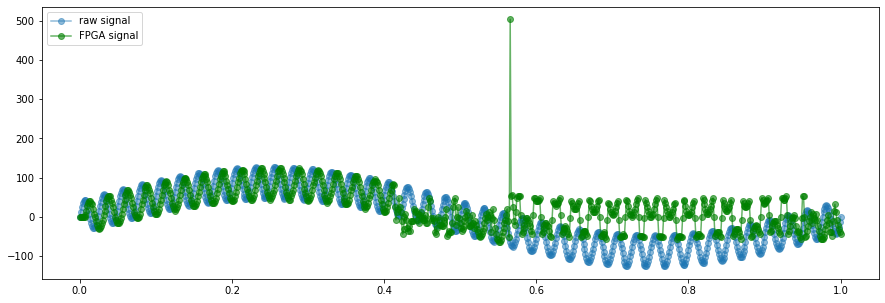

In [177]:
plt.figure(figsize=(15, 5))

plt.plot(t, signal, '-o',alpha=.5,label='raw signal')
plt.plot(t, fpga, '-o', color='g',alpha=.6,label='FPGA signal')

#plt.title("")
#plt.xlim(0,200) #just for the latex report
plt.legend(loc="upper left")
